## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_wavelet_full_pastis.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/wavelet/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

Running 12760 CDFs


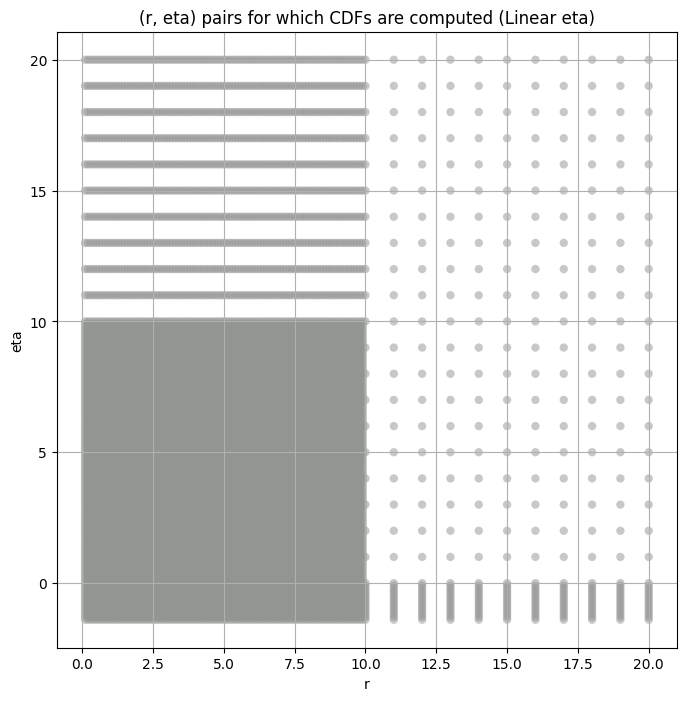

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:33<00:00, 2951.69it/s]


Layer 3


100%|██████████| 100000/100000 [00:41<00:00, 2396.51it/s]


Layer 4


100%|██████████| 100000/100000 [00:41<00:00, 2386.14it/s]


Layer 5


100%|██████████| 100000/100000 [00:41<00:00, 2388.33it/s]


Layer 6


100%|██████████| 100000/100000 [00:41<00:00, 2386.63it/s]


Layer 7


100%|██████████| 100000/100000 [07:01<00:00, 237.35it/s]


Layer 8


100%|██████████| 100000/100000 [03:08<00:00, 530.84it/s]


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1830.934600  1652.097700  2023.443800   2.933956    1.846394   
3       587.781860   556.332100   620.660600   2.604501    2.026207   
4       164.606740   154.984480   174.518840   3.278817    2.623241   
5        37.863530    35.388520    40.433693   4.789257    3.843992   
6         7.493805     6.929792     8.083941   6.740130    5.245897   
7         1.386997     1.272397     1.509542   9.084314    7.002164   
8         0.215883     0.196152     0.238341  12.285479    8.522737   

       kurt_upper  total_samples  
layer                             
2        4.126091         3180.0  
3        3.270645        12720.0  
4        4.093916        50880.0  
5        5.925406       203520.0  
6        8.892210       814080.0  
7       12.550997      3256320.0  
8       23.484678     13025280.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1830.934600    1830.934570     1452.429077     1276.170166   
3       587.781860     587.781860      541.575623      515.132324   
4       164.606740     164.606735      159.676453      156.378769   
5        37.863530      37.863529       37.043510       36.452328   
6         7.493805       7.493805        7.288052        7.147865   
7         1.386997       1.386997        1.341698        1.311312   
8         0.215883       0.215883        0.206941        0.201541   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         1145.674072      1040.546997       878.686707       749.599243   
3          493.123138       474.211823       442.020203       414.849426   
4          153.571075       151.044083       146.518402       142.496201   
5           35.938229        35.477501        34.660660        33.947586   
6            7.028977         6.923156         6.736482         6.573743   
7            1.285678         1.262962         1.223419         1.189016   
8            0.197070         0.193155         0.186390         0.180575   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           645.658875       561.035522       489.759491       327.872131  
3           391.358582       370.649902       351.753479       305.333282  
4           138.862274       135.548203       132.480392       124.381584  
5            33.302437        32.709419        32.163368        30.706472  
6             6.427655         6.294827         6.172112         5.849967  
7             1.158356         1.130504         1.104886         1.037957  
8             0.175420         0.170760         0.166490         0.155441

####
Layer  2


100%|██████████| 12760/12760 [00:04<00:00, 2765.51it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.01693687044877512 1830.9346


100%|██████████| 12760/12760 [00:02<00:00, 4490.24it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.017595623162453444 1452.4291


100%|██████████| 12760/12760 [00:02<00:00, 4476.87it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.027243392256098176 1276.1702


100%|██████████| 12760/12760 [00:03<00:00, 3711.21it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.036091927559000925 1145.6741


100%|██████████| 12760/12760 [00:03<00:00, 3597.38it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.04426198360858802 1040.547


100%|██████████| 12760/12760 [00:02<00:00, 4371.79it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.06085709274086737 878.6867


100%|██████████| 12760/12760 [00:02<00:00, 4273.63it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.07420008689549595 749.59924


100%|██████████| 12760/12760 [00:03<00:00, 4105.70it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.08731138965927854 645.6589


100%|██████████| 12760/12760 [00:02<00:00, 4370.17it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.10086500887854155 561.0355


100%|██████████| 12760/12760 [00:02<00:00, 4335.11it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.11468687334524219 489.7595


100%|██████████| 12760/12760 [00:02<00:00, 4292.45it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.1556635565286616 327.87213
Number of samples: 3180, Without approximation : 3180.0


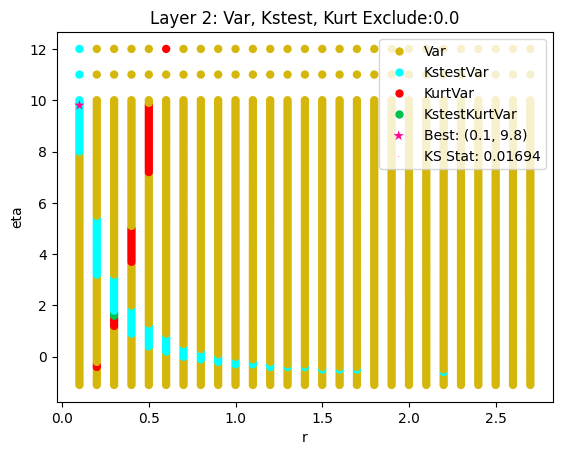

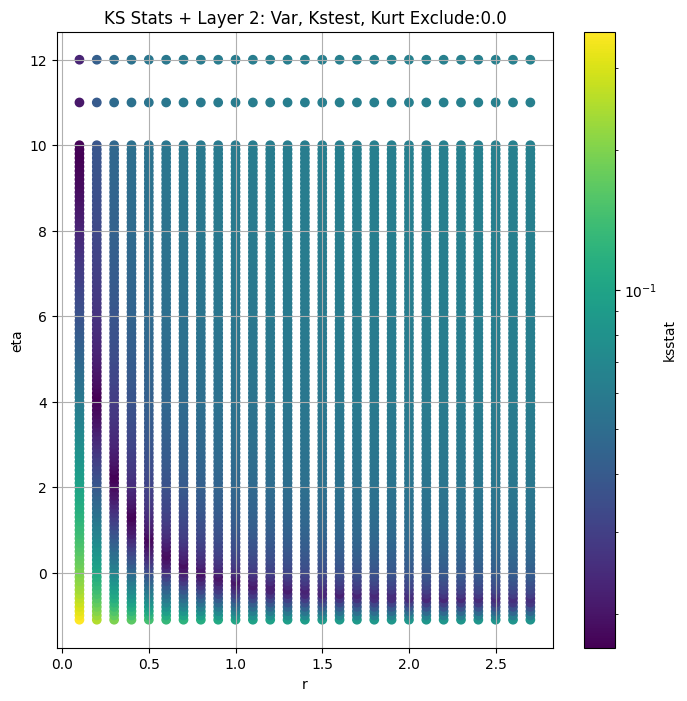

####
Layer  3


100%|██████████| 12760/12760 [00:09<00:00, 1317.30it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.004821581974641664 587.78186


100%|██████████| 12760/12760 [00:12<00:00, 1008.23it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.006802348292812677 541.5756


100%|██████████| 12760/12760 [00:10<00:00, 1216.48it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.008907133745377216 515.1323


100%|██████████| 12760/12760 [00:09<00:00, 1290.11it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.010842048368681079 493.12314


100%|██████████| 12760/12760 [00:11<00:00, 1158.31it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.012732634537401255 474.21182


100%|██████████| 12760/12760 [00:13<00:00, 942.29it/s] 


Finding Minimum after computing 12760 CDFs
3 150 0.016726891440936087 442.0202


100%|██████████| 12760/12760 [00:11<00:00, 1128.44it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.02126544487625026 414.84943


100%|██████████| 12760/12760 [00:10<00:00, 1258.45it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.025799098848271806 391.35858


100%|██████████| 12760/12760 [00:10<00:00, 1220.89it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.03010909334640377 370.6499


100%|██████████| 12760/12760 [00:10<00:00, 1167.10it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.03438221123542107 351.75348


100%|██████████| 12760/12760 [00:12<00:00, 1040.42it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.045638810357890525 305.33328
Number of samples: 12720, Without approximation : 12720.0


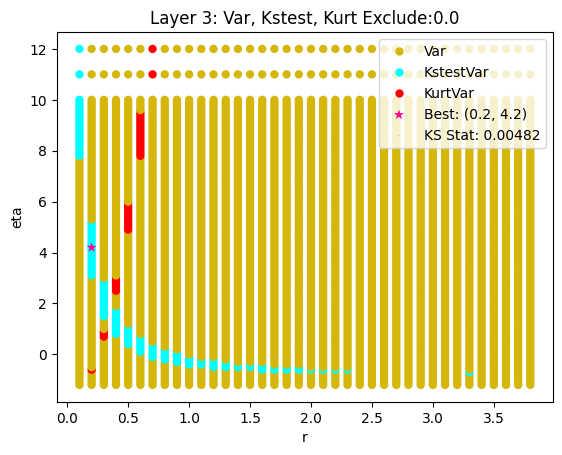

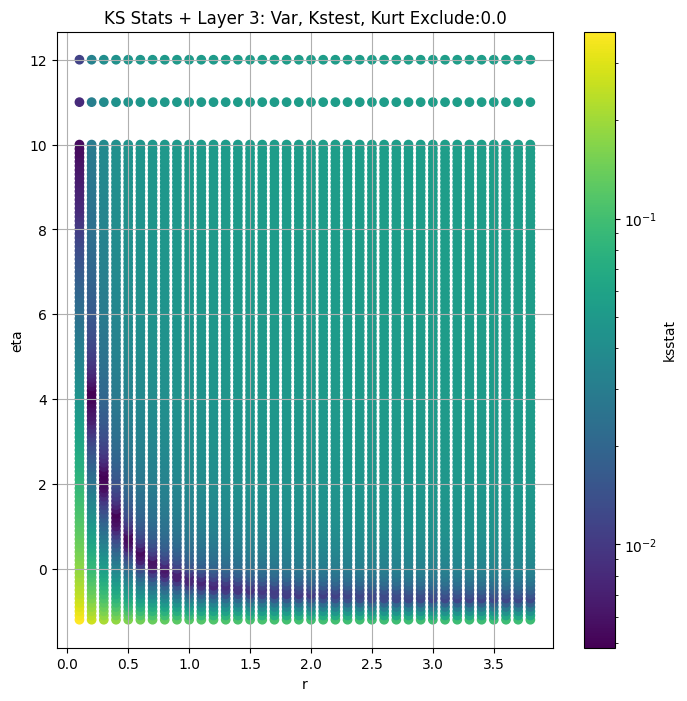

####
Layer  4


100%|██████████| 12760/12760 [00:36<00:00, 348.84it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.005104977665695121 164.60674


100%|██████████| 12760/12760 [00:36<00:00, 346.03it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.004951428936385838 159.67645


100%|██████████| 12760/12760 [00:39<00:00, 321.39it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.0053565938896628085 156.37877


100%|██████████| 12760/12760 [00:38<00:00, 328.73it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.00625167445272623 153.57108


100%|██████████| 12760/12760 [00:35<00:00, 363.47it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.006025291776695307 151.04408


100%|██████████| 12760/12760 [00:34<00:00, 368.36it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.007169379047953589 146.5184


100%|██████████| 12760/12760 [00:38<00:00, 328.56it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.00820961582594204 142.4962


100%|██████████| 12760/12760 [22:07<00:00,  9.61it/s]  


Finding Minimum after computing 12760 CDFs
4 250 0.009214459039785794 138.86227


100%|██████████| 12760/12760 [00:35<00:00, 359.22it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.010272584390466188 135.5482


100%|██████████| 12760/12760 [00:34<00:00, 372.23it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.011433718005818716 132.4804


100%|██████████| 12760/12760 [00:34<00:00, 370.05it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.014566562700159436 124.381584
Number of samples: 50880, Without approximation : 50880.0


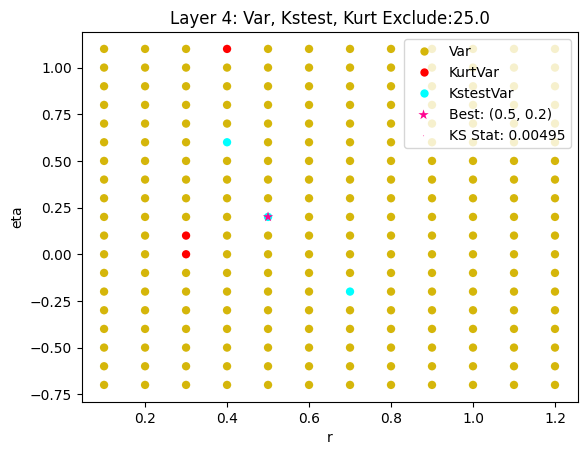

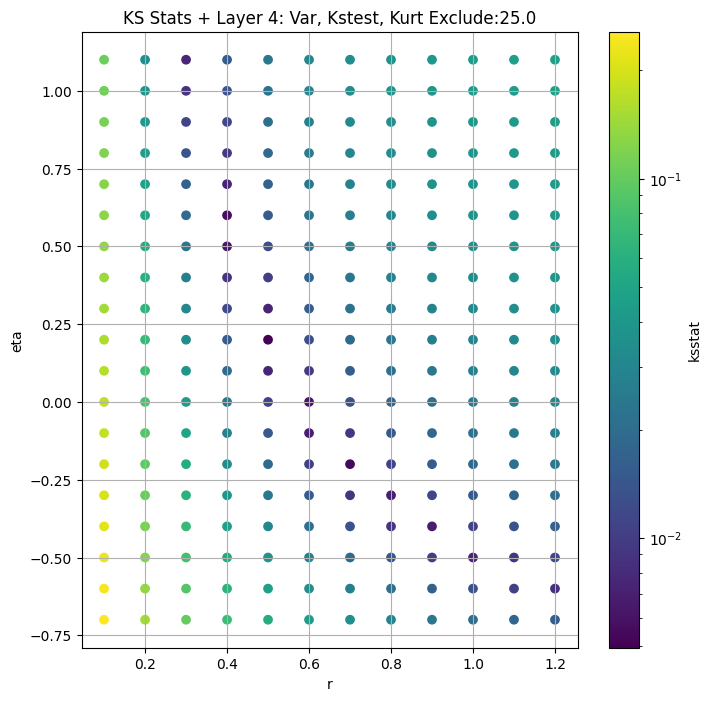

####
Layer  5


100%|██████████| 12760/12760 [13:42<00:00, 15.51it/s]  


Finding Minimum after computing 12760 CDFs
5 0 0.0021255617122832304 37.86353


100%|██████████| 12760/12760 [26:09<00:00,  8.13it/s]  


Finding Minimum after computing 12760 CDFs
5 25 0.002560772528162447 37.04351


100%|██████████| 12760/12760 [01:11<00:00, 177.58it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.003215083347724801 36.452328


100%|██████████| 12760/12760 [01:06<00:00, 192.50it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.003380668988272162 35.93823


100%|██████████| 12760/12760 [17:54<00:00, 11.87it/s]  


Finding Minimum after computing 12760 CDFs
5 100 0.0036383850665596684 35.4775


100%|██████████| 12760/12760 [1:04:45<00:00,  3.28it/s]  


Finding Minimum after computing 12760 CDFs
5 150 0.0042906774843252116 34.66066


100%|██████████| 12760/12760 [01:09<00:00, 182.71it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.005090319657061859 33.947586


100%|██████████| 12760/12760 [11:53<00:00, 17.87it/s] 


Finding Minimum after computing 12760 CDFs
5 250 0.005592144399578558 33.302437


100%|██████████| 12760/12760 [13:23<00:00, 15.88it/s]  


Finding Minimum after computing 12760 CDFs
5 300 0.006261872677001623 32.70942


100%|██████████| 12760/12760 [06:51<00:00, 31.03it/s] 


Finding Minimum after computing 12760 CDFs
5 350 0.006829775510859282 32.16337


100%|██████████| 12760/12760 [04:35<00:00, 46.32it/s] 


Finding Minimum after computing 12760 CDFs
5 500 0.008432835959478857 30.706472
Number of samples: 100000, Without approximation : 203520.0


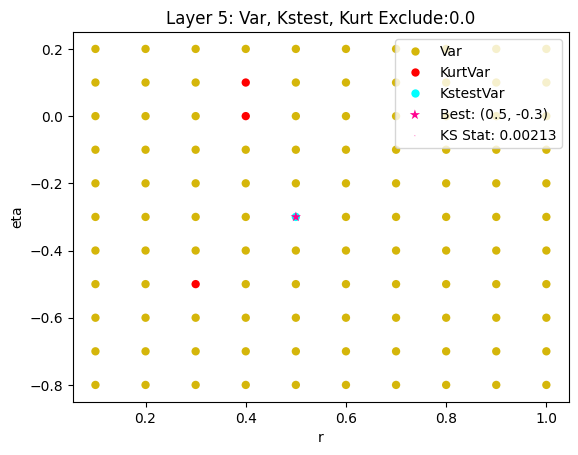

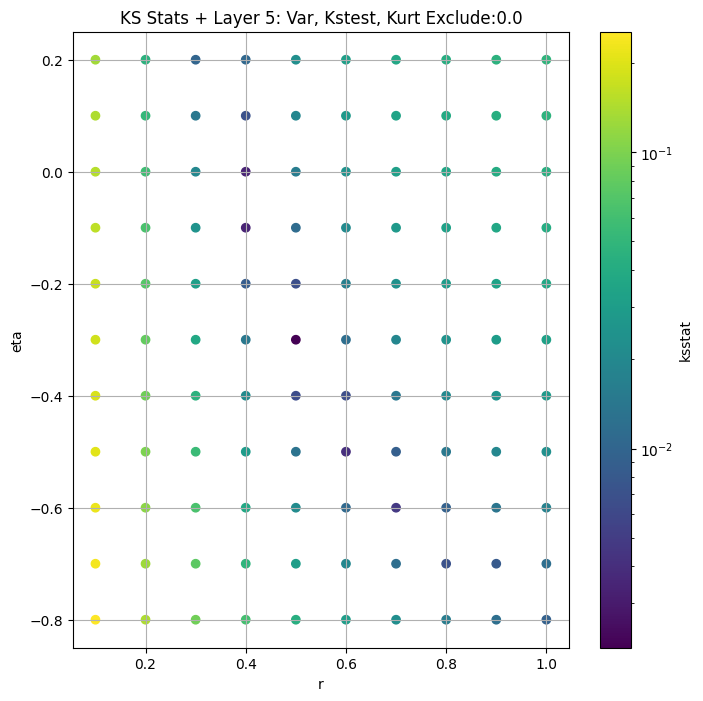

####
Layer  6


100%|██████████| 12760/12760 [01:13<00:00, 172.86it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.004259578530028008 7.493805


100%|██████████| 12760/12760 [04:33<00:00, 46.58it/s] 


Finding Minimum after computing 12760 CDFs
6 25 0.0033494860600522536 7.288052


100%|██████████| 12760/12760 [03:27<00:00, 61.45it/s] 


Finding Minimum after computing 12760 CDFs
6 50 0.004151410217648754 7.1478653


100%|██████████| 12760/12760 [01:12<00:00, 175.65it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.005226109646482735 7.0289774


100%|██████████| 12760/12760 [01:08<00:00, 186.58it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.005722990278863582 6.923156


100%|██████████| 12760/12760 [01:08<00:00, 187.55it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.005092527641958222 6.736482


100%|██████████| 12760/12760 [01:11<00:00, 179.38it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.00618418468097881 6.573743


100%|██████████| 12760/12760 [01:08<00:00, 185.58it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.00591314203985005 6.4276547


100%|██████████| 12760/12760 [01:07<00:00, 190.34it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.006311302419582554 6.294827


100%|██████████| 12760/12760 [01:09<00:00, 184.04it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.006966815448565367 6.1721125


100%|██████████| 12760/12760 [01:10<00:00, 181.86it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.008589854562145893 5.8499665
Number of samples: 100000, Without approximation : 814080.0


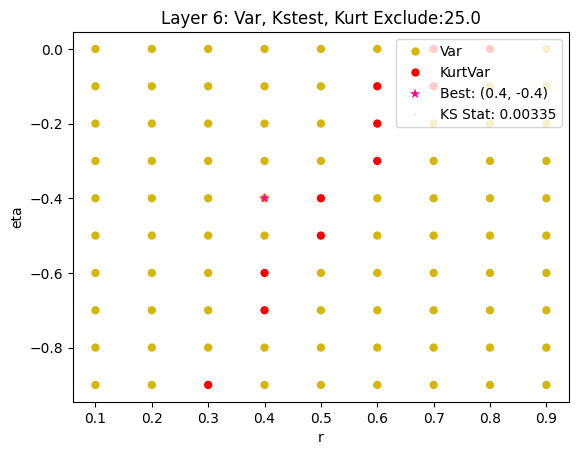

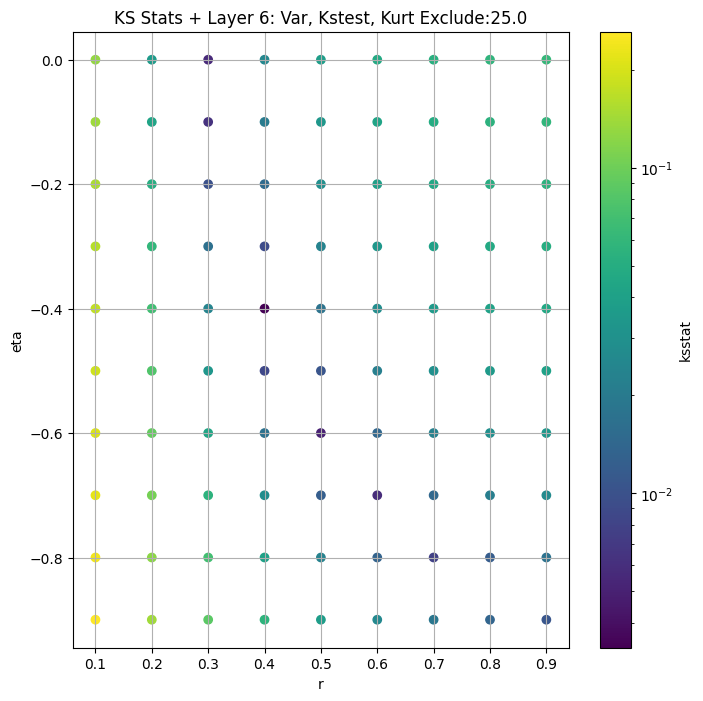

####
Layer  7


100%|██████████| 12760/12760 [01:09<00:00, 182.34it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.00555571268511712 1.3869972


100%|██████████| 12760/12760 [01:08<00:00, 187.15it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.006328579404048684 1.341698


100%|██████████| 12760/12760 [01:11<00:00, 179.70it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.006953528572505974 1.3113118


100%|██████████| 12760/12760 [01:08<00:00, 185.65it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.007235091038293673 1.2856779


100%|██████████| 12760/12760 [01:14<00:00, 170.83it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.006215445854252322 1.2629622


100%|██████████| 12760/12760 [01:07<00:00, 189.59it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.0069072691700582944 1.2234186


100%|██████████| 12760/12760 [01:07<00:00, 187.67it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.00790503779919527 1.1890159


100%|██████████| 12760/12760 [01:07<00:00, 188.04it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.007147146165555007 1.1583558


100%|██████████| 12760/12760 [01:10<00:00, 181.61it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.008172361498095637 1.1305045


100%|██████████| 12760/12760 [01:16<00:00, 165.99it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.008775888305139812 1.104886


100%|██████████| 12760/12760 [02:41<00:00, 79.12it/s] 


Finding Minimum after computing 12760 CDFs
7 500 0.01004998809794122 1.037957
Number of samples: 100000, Without approximation : 3256320.0


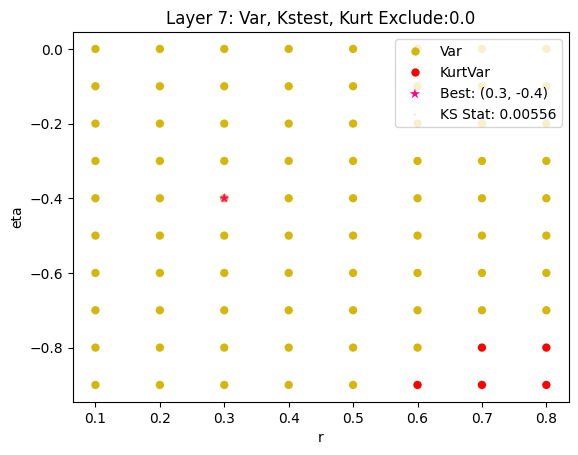

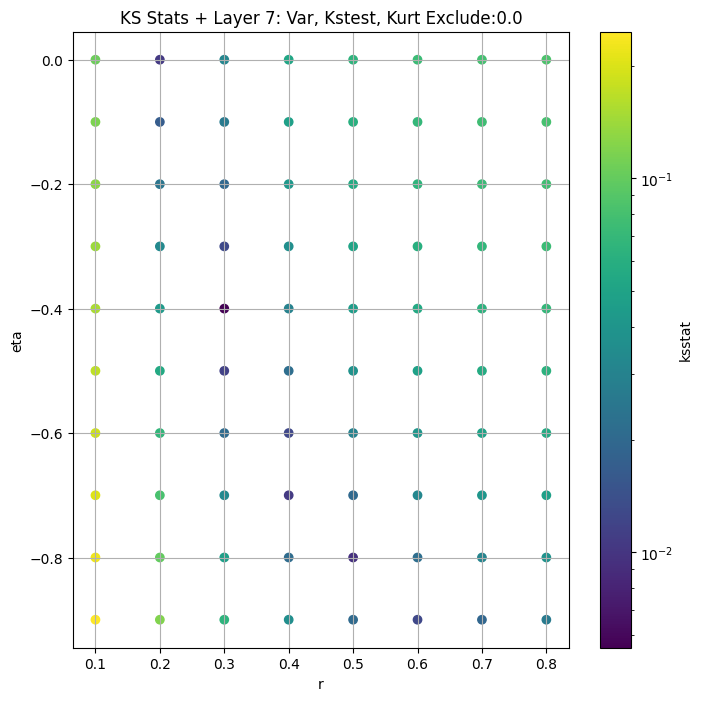

####
Layer  8


100%|██████████| 12760/12760 [05:10<00:00, 41.13it/s] 


Finding Minimum after computing 12760 CDFs
8 0 0.00695217221427924 0.21588294


100%|██████████| 12760/12760 [09:56<00:00, 21.38it/s]  


Finding Minimum after computing 12760 CDFs
8 25 0.008021784580896474 0.20694143


100%|██████████| 12760/12760 [01:07<00:00, 189.77it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.008111681846482033 0.20154075


100%|██████████| 12760/12760 [01:06<00:00, 191.28it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.007366113903875426 0.19706982


100%|██████████| 12760/12760 [01:09<00:00, 183.43it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.008224157603059168 0.19315535


100%|██████████| 12760/12760 [01:07<00:00, 190.40it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.008068655017396953 0.18639039


100%|██████████| 12760/12760 [01:14<00:00, 172.40it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.008452408334029715 0.18057492


100%|██████████| 12760/12760 [01:08<00:00, 186.36it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.009640740090504196 0.17541991


100%|██████████| 12760/12760 [01:06<00:00, 192.10it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.009613145734560069 0.1707596


100%|██████████| 12760/12760 [01:08<00:00, 186.58it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.00964558086488021 0.16649014


100%|██████████| 12760/12760 [01:06<00:00, 191.33it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.010960228347525747 0.15544103
Number of samples: 100000, Without approximation : 13025280.0


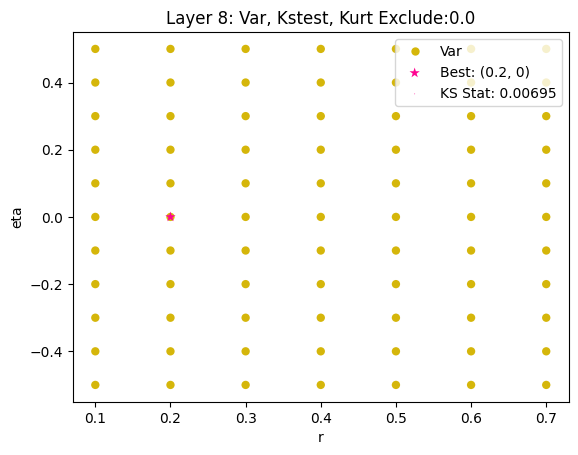

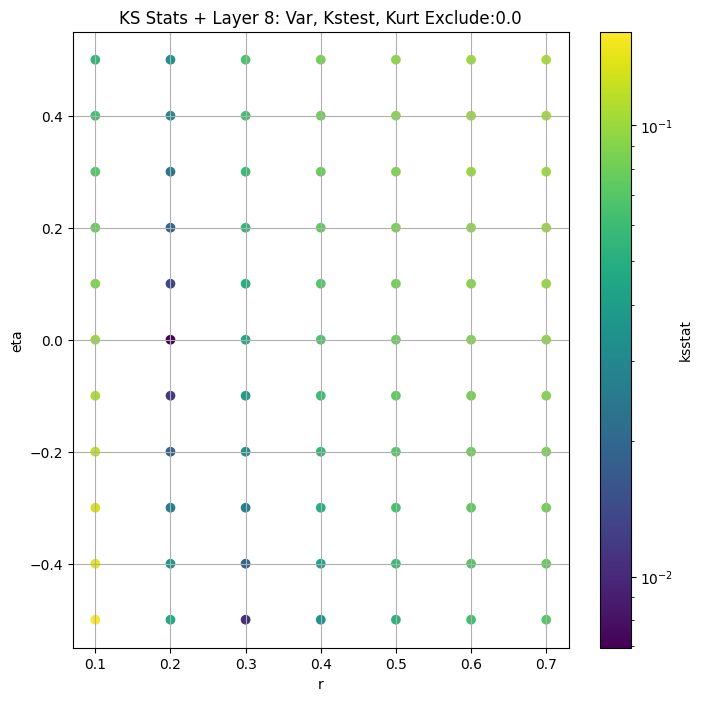

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1830.934600  1652.097700  2023.443800   2.933956    1.846394   
3       587.781860   556.332100   620.660600   2.604501    2.026207   
4       164.606740   154.984480   174.518840   3.278817    2.623241   
5        37.863530    35.388520    40.433693   4.789257    3.843992   
6         7.493805     6.929792     8.083941   6.740130    5.245897   
7         1.386997     1.272397     1.509542   9.084314    7.002164   
8         0.215883     0.196152     0.238341  12.285479    8.522737   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.126091         3180.0             0.016937        0.1          9.8   
3        3.270645        12720.0             0.004822        0.2          4.2   
4        4.093916        50880.0             0.004951        0.5          0.2   
5        5.925406       203520.0             0.002126        0.5         -0.3   
6        8.892210       814080.0             0.003349        0.4         -0.4   
7       12.550997      3256320.0             0.005556        0.3         -0.4   
8       23.484678     13025280.0             0.006952        0.2          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       3.660938e-18                     0.0         1830.934600   
3       2.239008e-05                     0.0          587.781860   
4       1.067356e+01                    25.0          159.676450   
5       4.640138e+00                     0.0           37.863530   
6       3.328961e-01                    25.0            7.288052   
7       7.729045e-03                     0.0            1.386997   
8       2.952075e-06                     0.0            0.215883   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.024030  
3                     0.012029  
4                     0.006018  
5                     0.003010  
6                     0.001505  
7                     0.000753  
8                     0.000376

In [ ]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 405/405 [00:00<00:00, 1774.87it/s]


Finding Minimum after computing 405 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.047270749453939054, var: 1040.5469970703125


100%|██████████| 405/405 [00:00<00:00, 4466.25it/s]


Finding Minimum after computing 405 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.037943719522571584, var: 1145.674072265625


100%|██████████| 405/405 [00:00<00:00, 4349.38it/s]


Finding Minimum after computing 405 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.028993649238315822, var: 1276.170166015625


100%|██████████| 405/405 [00:00<00:00, 4512.23it/s]


Finding Minimum after computing 405 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.02215266518993636, var: 1452.4290771484375


100%|██████████| 405/405 [00:00<00:00, 4516.26it/s]


Finding Minimum after computing 405 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.01693687044877512, var: 1830.9345703125
Number of samples: 3180, Without approximation : 3180.0


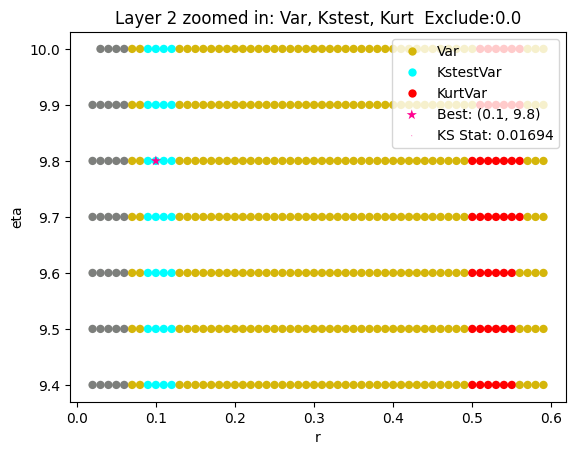

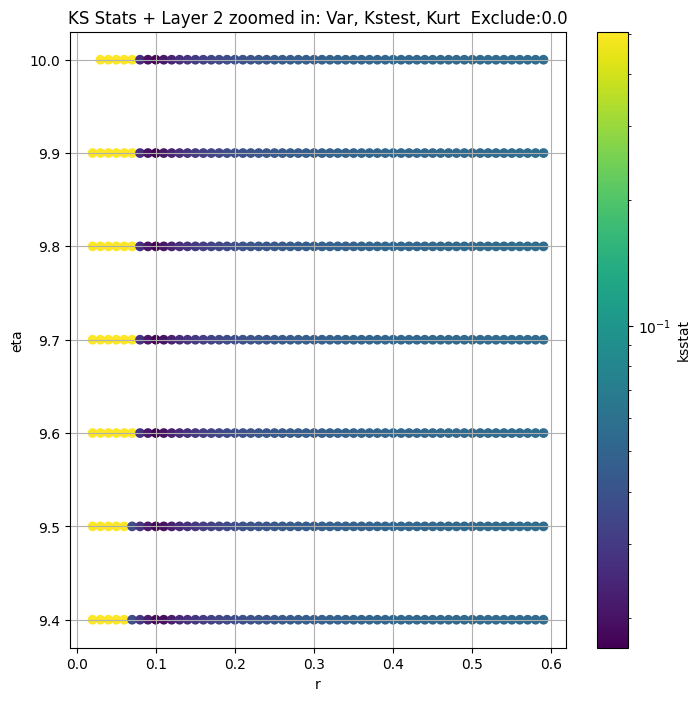

Layer 3


100%|██████████| 621/621 [00:00<00:00, 955.43it/s]


Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.015687335722438855, var: 474.2118225097656


100%|██████████| 621/621 [00:00<00:00, 1404.65it/s]


Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.013504051611701873, var: 493.1231384277344


100%|██████████| 621/621 [00:00<00:00, 1390.37it/s]


Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.011158082165795058, var: 515.13232421875


100%|██████████| 621/621 [00:00<00:00, 1388.20it/s]


Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.008569582871693626, var: 541.5756225585938


100%|██████████| 621/621 [00:00<00:00, 1385.32it/s]


Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.004790849628677929, var: 587.7818603515625
Number of samples: 12720, Without approximation : 12720.0


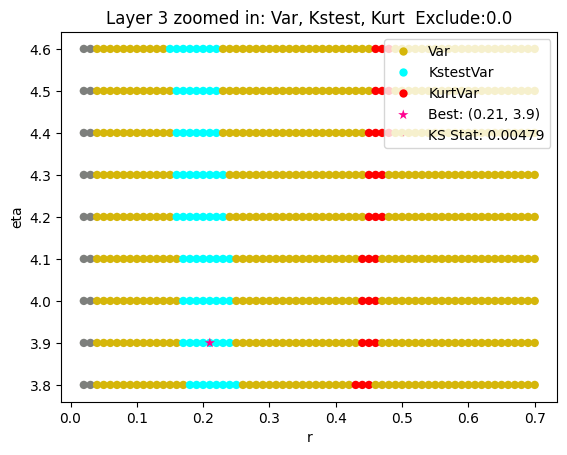

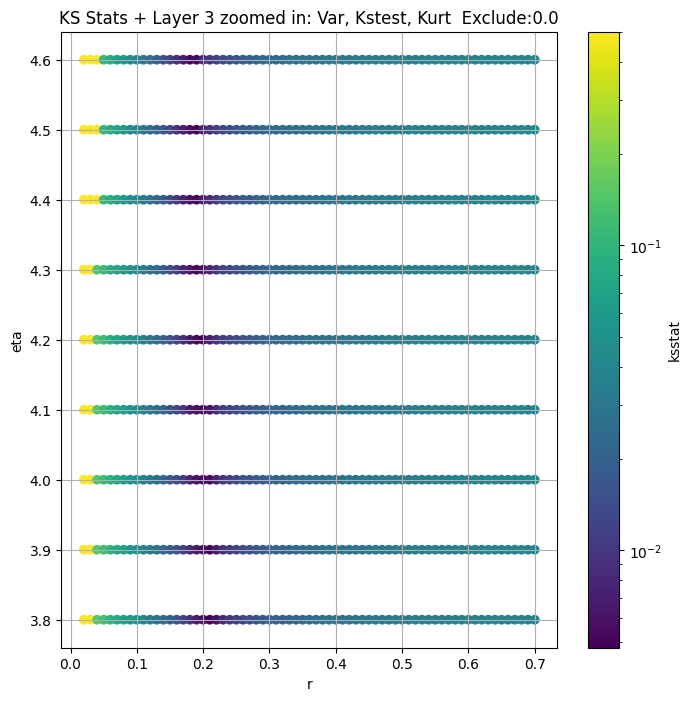

Layer 4


100%|██████████| 1223/1223 [00:03<00:00, 329.67it/s]


Finding Minimum after computing 1223 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.0070363075088794025, var: 148.71475219726562


100%|██████████| 1223/1223 [00:03<00:00, 367.88it/s]


Finding Minimum after computing 1223 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.006434366416400272, var: 151.04408264160156


100%|██████████| 1223/1223 [00:03<00:00, 373.23it/s]


Finding Minimum after computing 1223 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.005611809681149826, var: 153.57107543945312


100%|██████████| 1223/1223 [00:03<00:00, 373.18it/s]


Finding Minimum after computing 1223 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.005038087763519994, var: 156.37876892089844


100%|██████████| 1223/1223 [00:03<00:00, 373.83it/s]


Finding Minimum after computing 1223 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.004879036489315092, var: 159.67645263671875


100%|██████████| 1223/1223 [00:03<00:00, 371.60it/s]


Finding Minimum after computing 1223 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.004919686818396551, var: 164.6067352294922
Number of samples: 50880, Without approximation : 50880.0


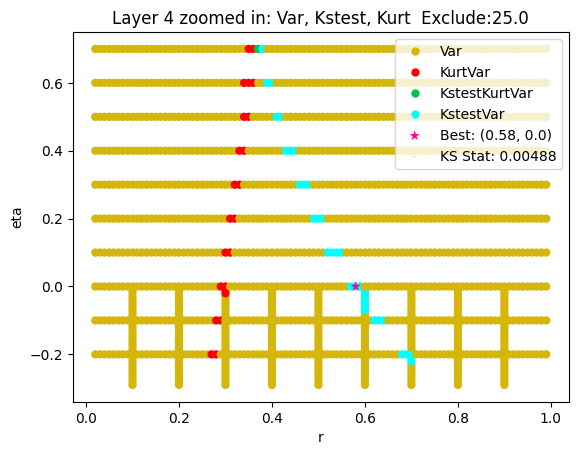

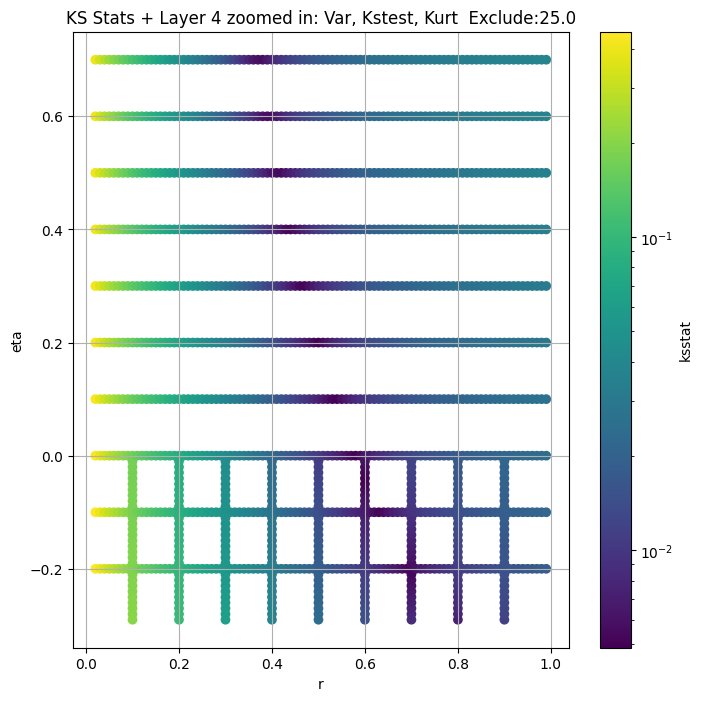

Layer 5


100%|██████████| 1530/1530 [00:08<00:00, 186.48it/s]


Finding Minimum after computing 1530 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.0035919385815670335, var: 35.477500915527344


100%|██████████| 1530/1530 [00:07<00:00, 193.34it/s]


Finding Minimum after computing 1530 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.003157813453453562, var: 35.938228607177734


100%|██████████| 1530/1530 [00:07<00:00, 192.16it/s]


Finding Minimum after computing 1530 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.002815684709275179, var: 36.452327728271484


100%|██████████| 1530/1530 [00:07<00:00, 193.22it/s]


Finding Minimum after computing 1530 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.002473810444309721, var: 37.04351043701172


100%|██████████| 1530/1530 [00:07<00:00, 192.95it/s]


Finding Minimum after computing 1530 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0020585347175915425, var: 37.863529205322266
Number of samples: 100000, Without approximation : 203520.0


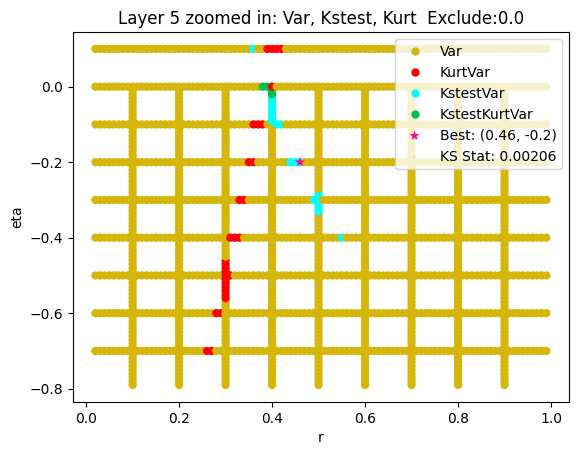

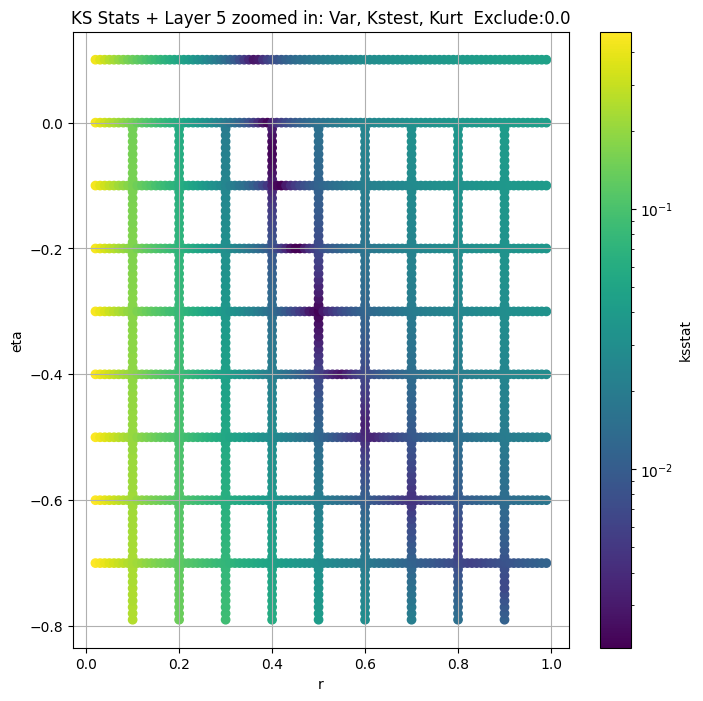

Layer 6


100%|██████████| 1440/1440 [00:07<00:00, 190.93it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 25.0 + 100 = 125, ksstat: 0.004279845282966099, var: 6.826190948486328


100%|██████████| 1440/1440 [00:07<00:00, 193.16it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 25.0 + 75 = 100, ksstat: 0.004045962525557001, var: 6.923155784606934


100%|██████████| 1440/1440 [00:07<00:00, 193.11it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 25.0 + 50 = 75, ksstat: 0.003852749887115259, var: 7.028977394104004


100%|██████████| 1440/1440 [00:07<00:00, 193.09it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 25.0 + 25 = 50, ksstat: 0.0035471796555328616, var: 7.147865295410156


100%|██████████| 1440/1440 [00:07<00:00, 192.45it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 25.0 + 0 = 25, ksstat: 0.0030659576658849663, var: 7.288052082061768


100%|██████████| 1440/1440 [00:07<00:00, 192.83it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 25.0 + -25 = 0, ksstat: 0.0031584823591819244, var: 7.493804931640625
Number of samples: 100000, Without approximation : 814080.0


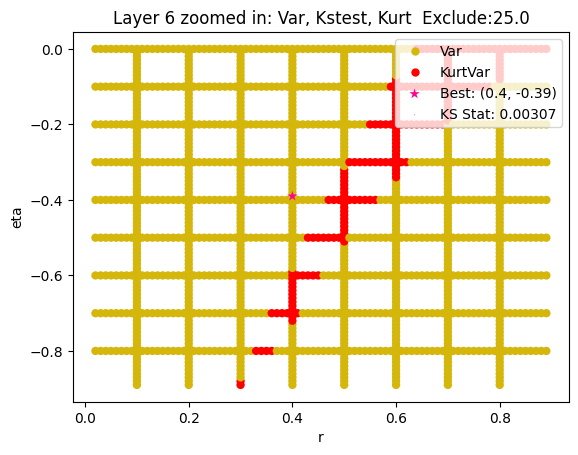

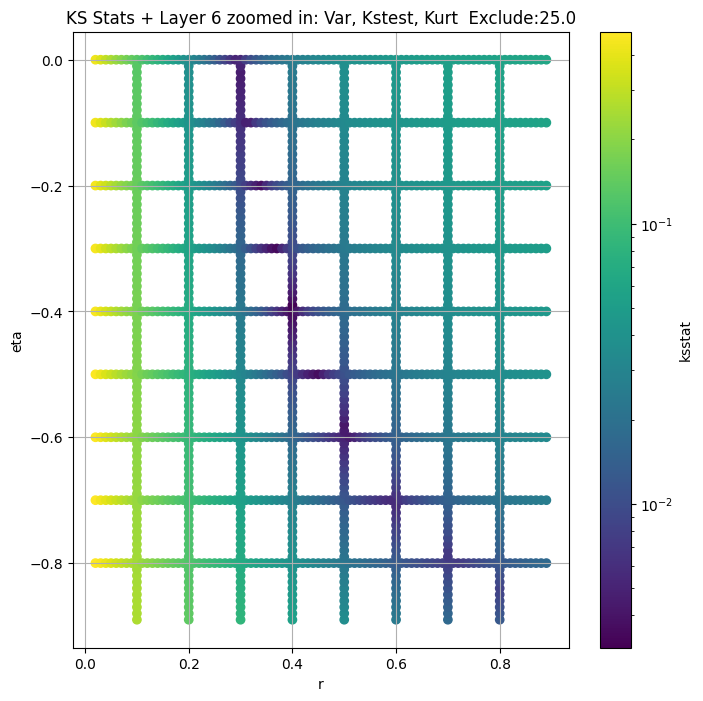

Layer 7


100%|██████████| 1269/1269 [00:06<00:00, 192.27it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.0061724301924308556, var: 1.2629622220993042


100%|██████████| 1269/1269 [00:06<00:00, 193.07it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.00569517276154341, var: 1.2856779098510742


100%|██████████| 1269/1269 [00:06<00:00, 193.28it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.005507916780750466, var: 1.3113118410110474


100%|██████████| 1269/1269 [00:06<00:00, 193.46it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.005078245115493596, var: 1.3416980504989624


100%|██████████| 1269/1269 [00:06<00:00, 192.97it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.005270240619003941, var: 1.3869972229003906
Number of samples: 100000, Without approximation : 3256320.0


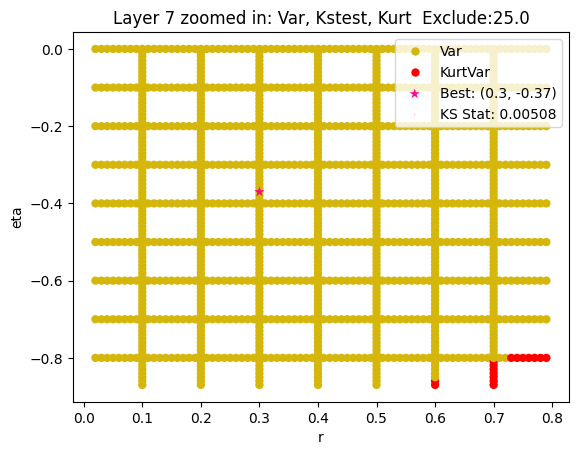

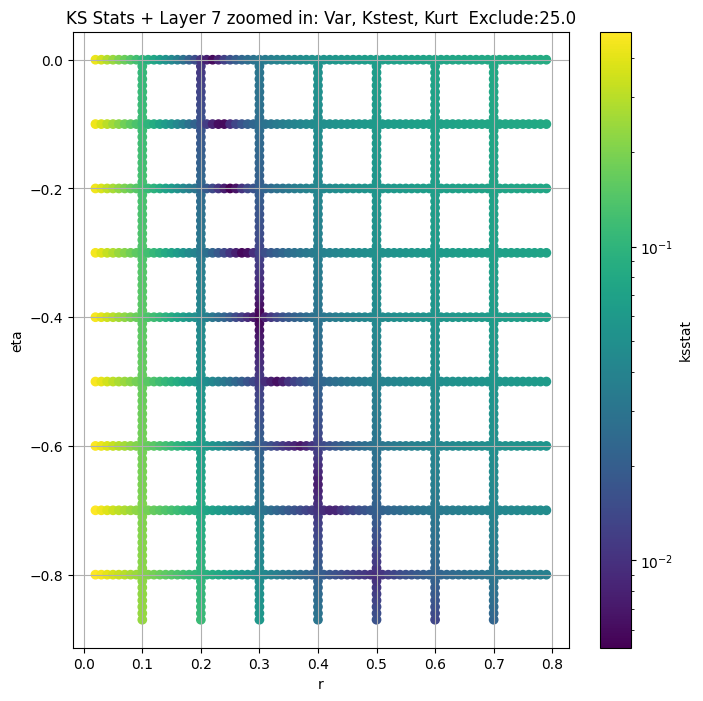

Layer 8


100%|██████████| 936/936 [00:05<00:00, 184.15it/s]


Finding Minimum after computing 936 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.007371141820855187, var: 0.19315534830093384


100%|██████████| 936/936 [00:04<00:00, 193.32it/s]


Finding Minimum after computing 936 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.007350425827877594, var: 0.19706982374191284


100%|██████████| 936/936 [00:04<00:00, 192.35it/s]


Finding Minimum after computing 936 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.007018121556567114, var: 0.2015407532453537


100%|██████████| 936/936 [00:04<00:00, 192.21it/s]


Finding Minimum after computing 936 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.006658080718872084, var: 0.2069414258003235


100%|██████████| 936/936 [00:04<00:00, 193.13it/s]


Finding Minimum after computing 936 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.006035225463215332, var: 0.21588294208049774
Number of samples: 100000, Without approximation : 13025280.0


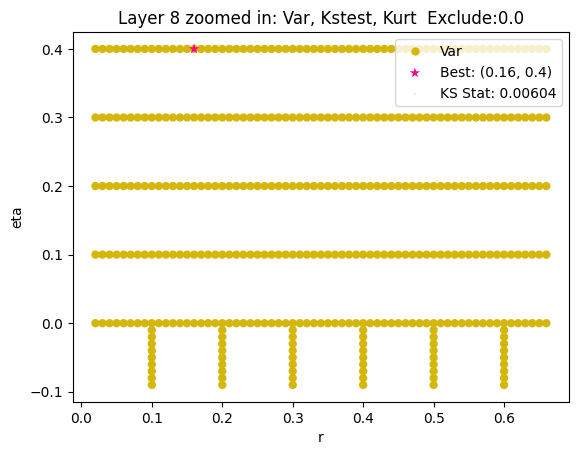

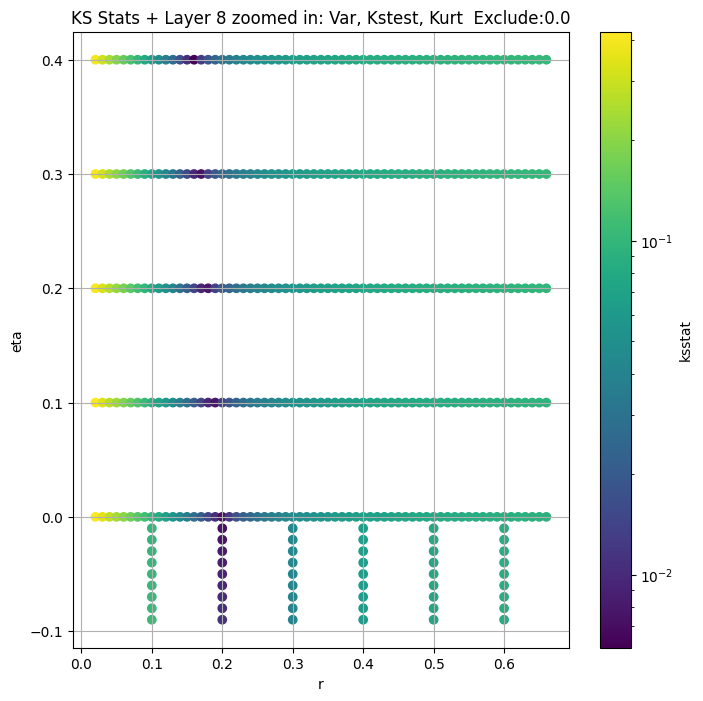

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1830.934600  1652.097700  2023.443800   2.933956    1.846394   
3       587.781860   556.332100   620.660600   2.604501    2.026207   
4       164.606740   154.984480   174.518840   3.278817    2.623241   
5        37.863530    35.388520    40.433693   4.789257    3.843992   
6         7.493805     6.929792     8.083941   6.740130    5.245897   
7         1.386997     1.272397     1.509542   9.084314    7.002164   
8         0.215883     0.196152     0.238341  12.285479    8.522737   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.126091         3180.0             0.016937        0.1          9.8   
3        3.270645        12720.0             0.004822        0.2          4.2   
4        4.093916        50880.0             0.004951        0.5          0.2   
5        5.925406       203520.0             0.002126        0.5         -0.3   
6        8.892210       814080.0             0.003349        0.4         -0.4   
7       12.550997      3256320.0             0.005556        0.3         -0.4   
8       23.484678     13025280.0             0.006952        0.2          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       3.660938e-18                     0.0         1830.934600   
3       2.239008e-05                     0.0          587.781860   
4       1.067356e+01                    25.0          159.676453   
5       4.640138e+00                     0.0           37.863529   
6       3.328961e-01                    25.0            7.288052   
7       7.729045e-03                     0.0            1.341698   
8       2.952075e-06                     0.0            0.215883   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.024030          0.016937    0.10      9.80   
3                     0.012029          0.004791    0.21      3.90   
4                     0.006018          0.004879    0.58      0.00   
5                     0.003010          0.002059    0.46     -0.20   
6                     0.001505          0.003066    0.40     -0.39   
7                     0.000753          0.005078    0.30     -0.37   
8                     0.000376          0.006035    0.16      0.40   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      3.660938e-18                  0.0         6787  
3      8.138773e-05                  0.0        81499  
4      2.516293e+01                 25.0        76320  
5      2.703940e+00                  0.0       457920  
6      3.268085e-01                 25.0       203520  
7      6.965467e-03                 25.0        72444  
8      1.248581e-08                  0.0        50880

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

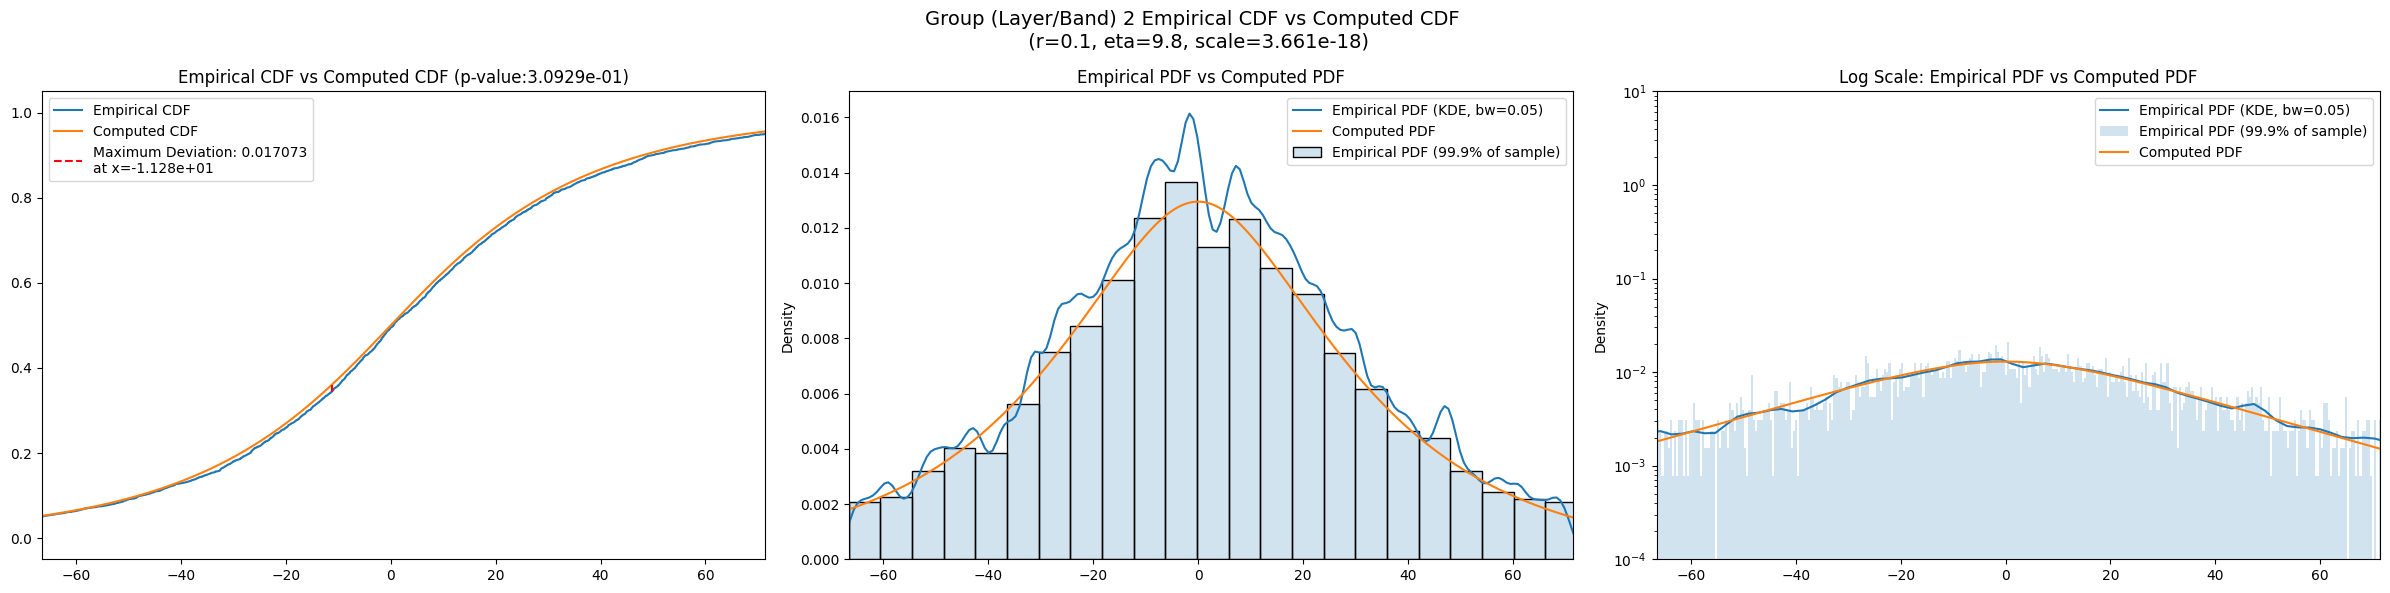

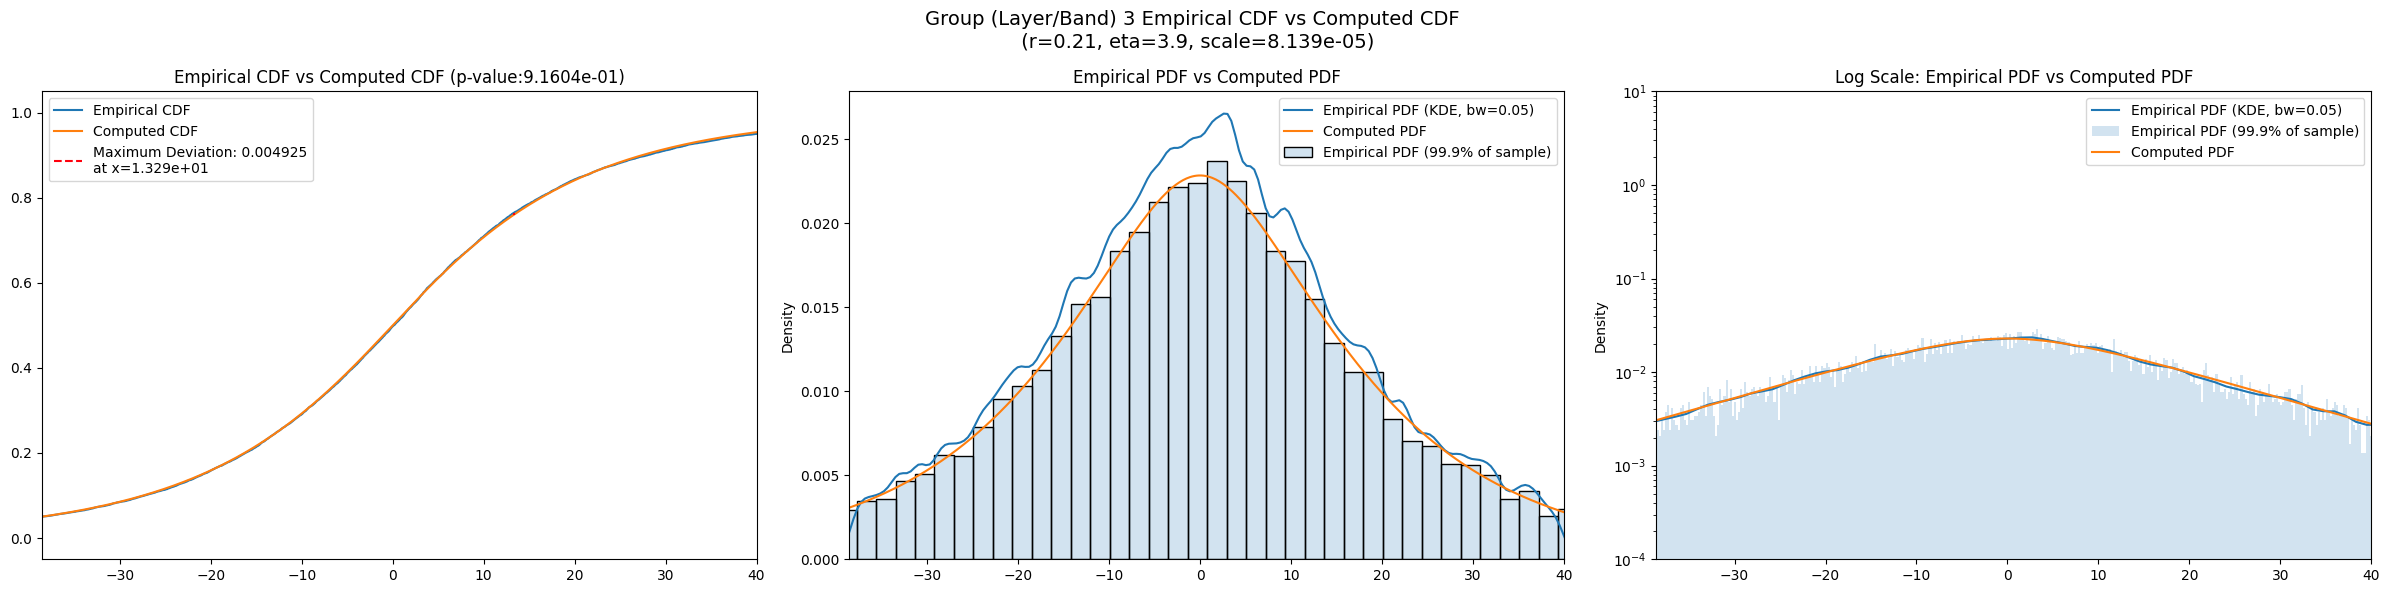

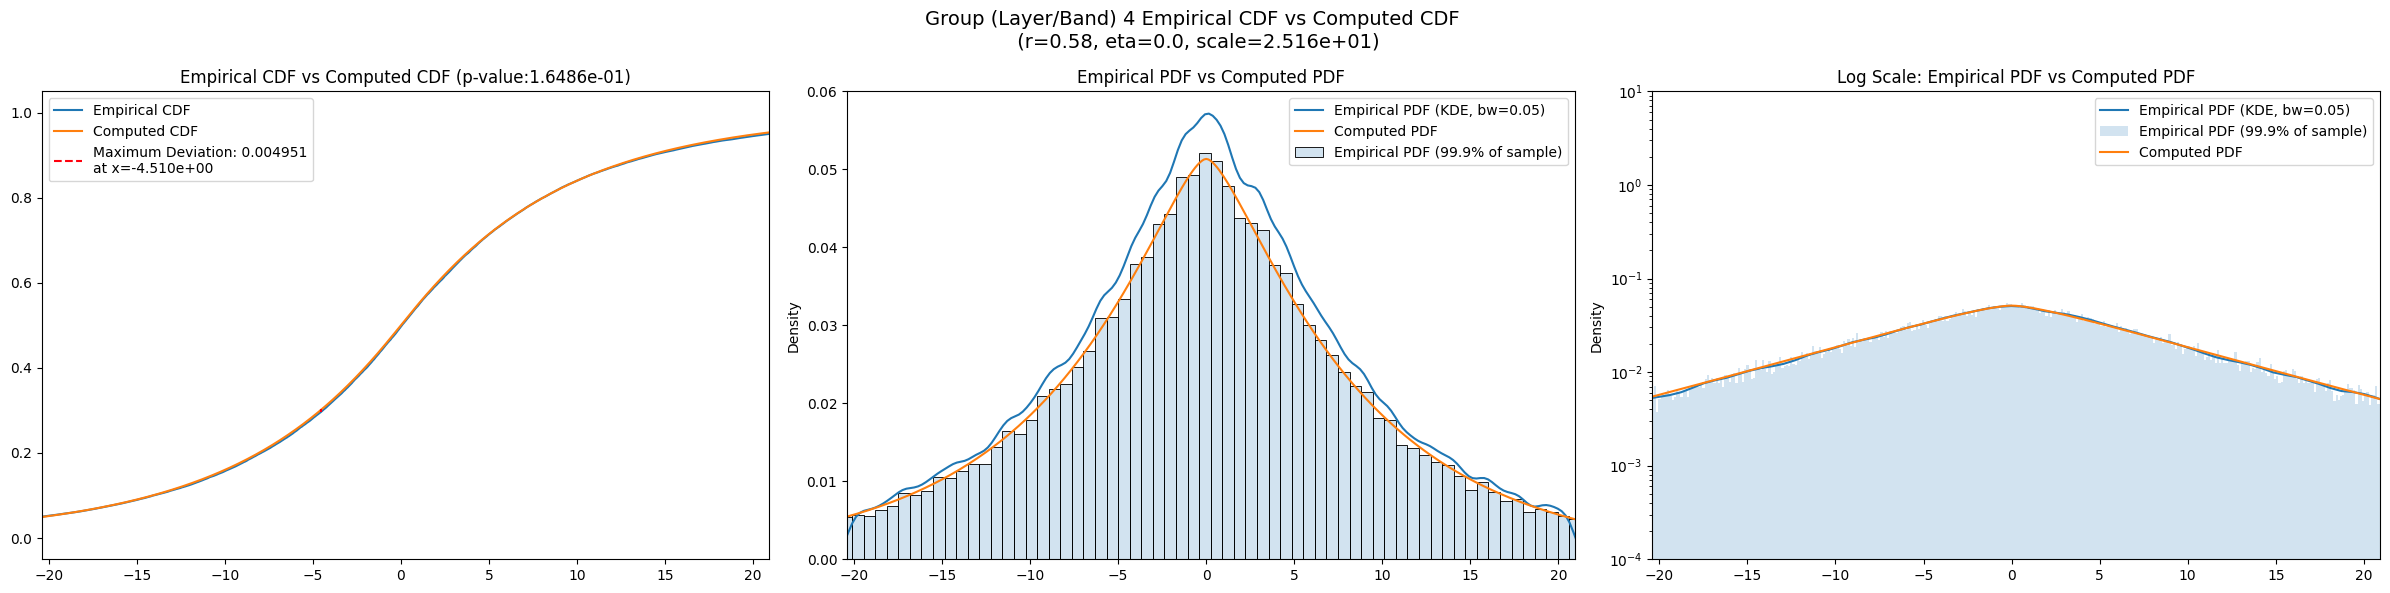

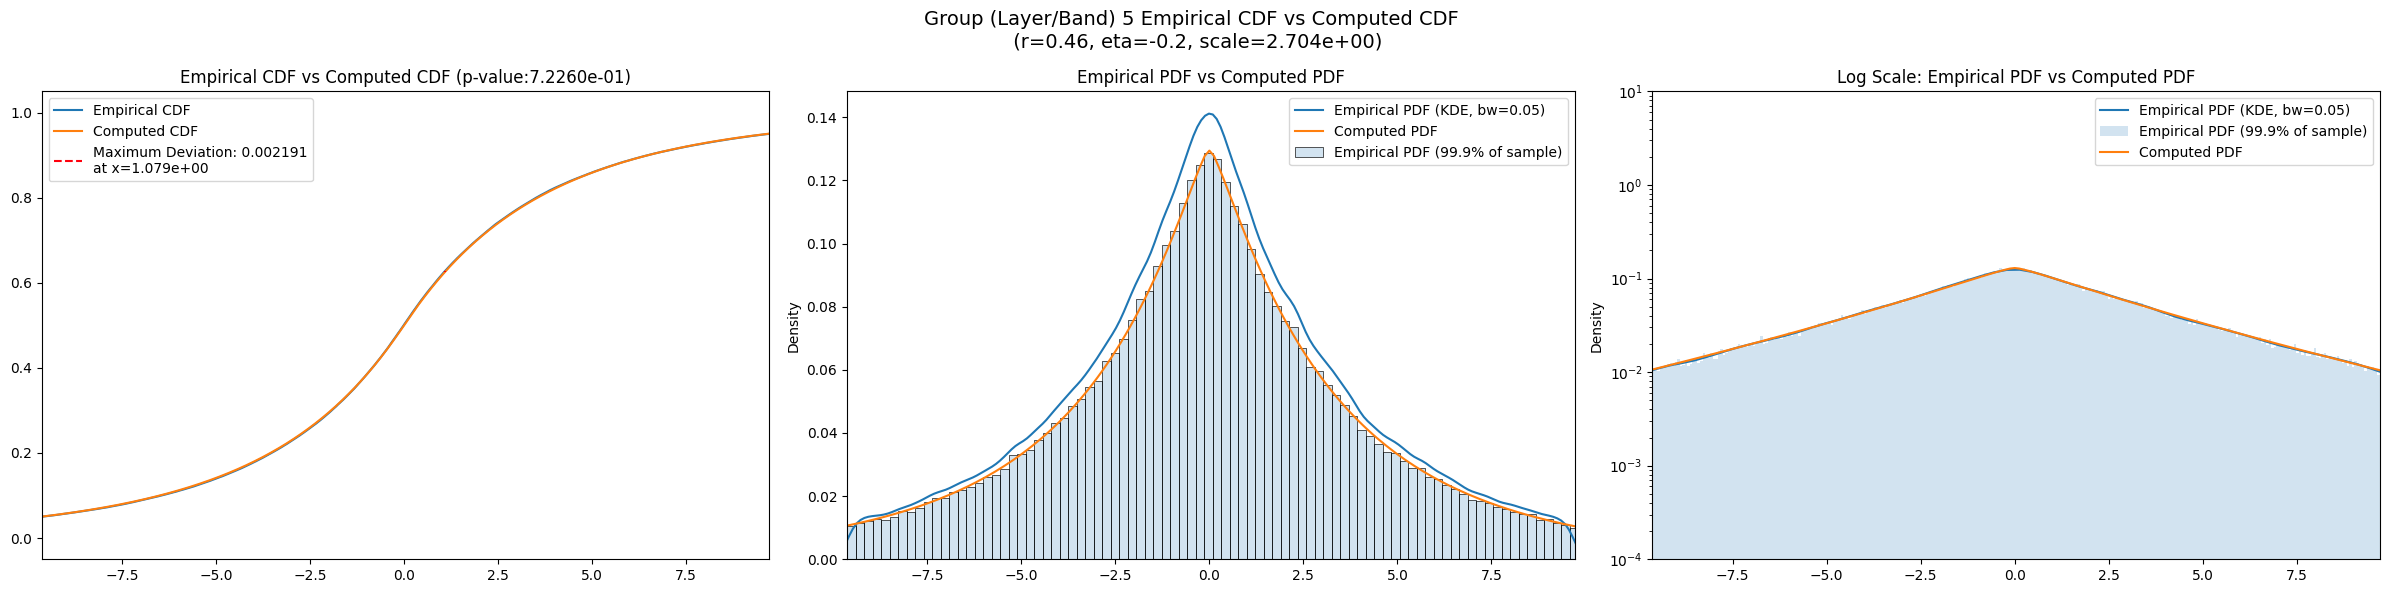

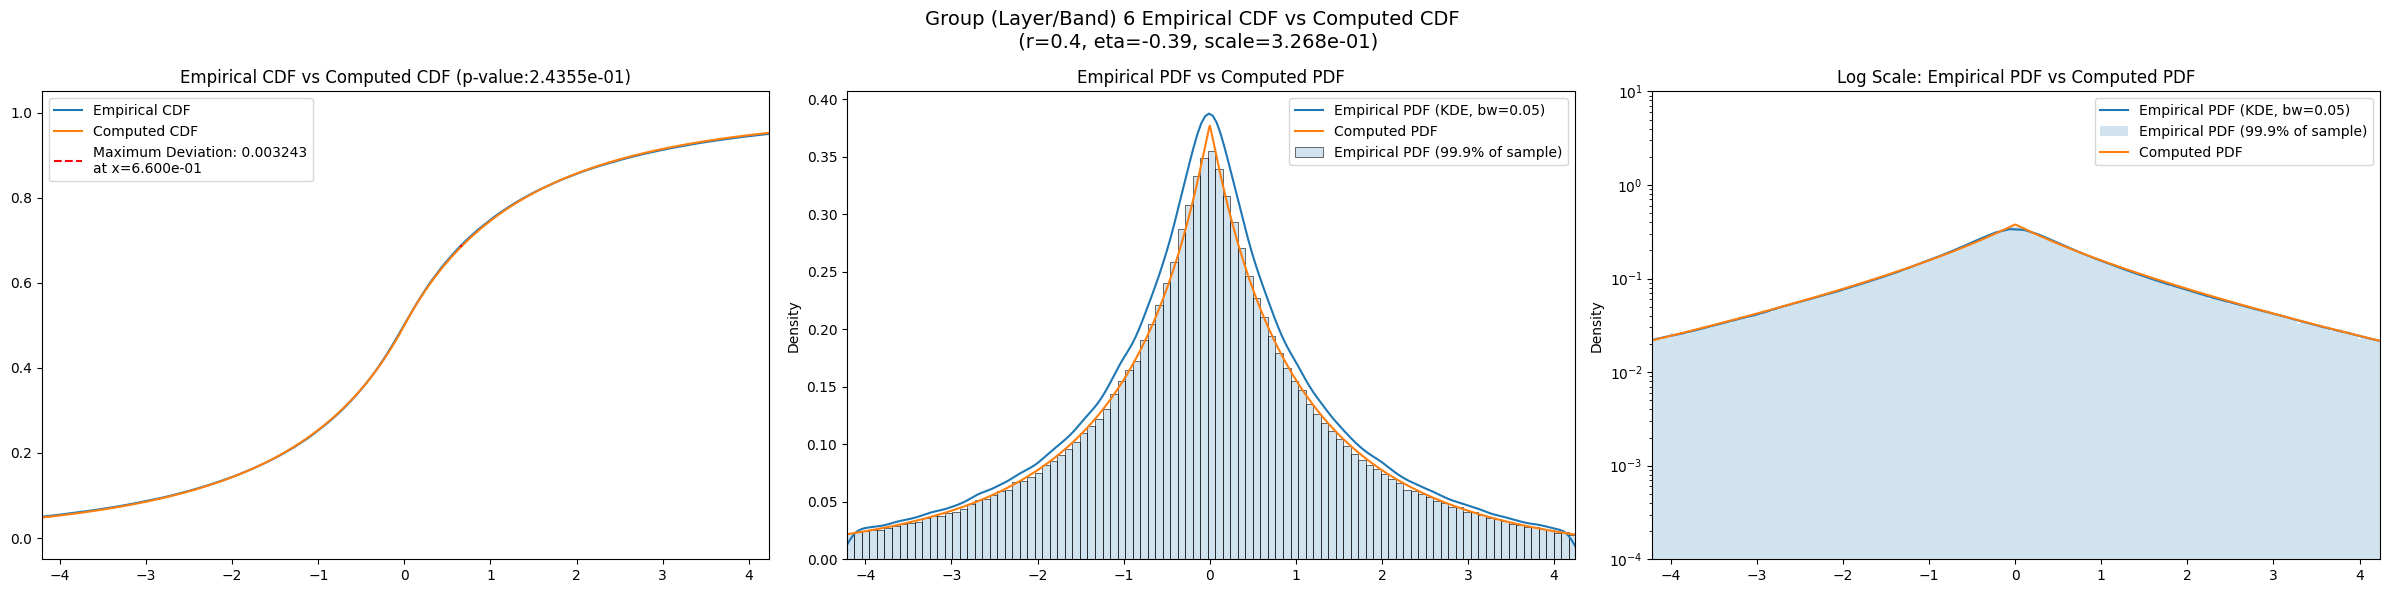

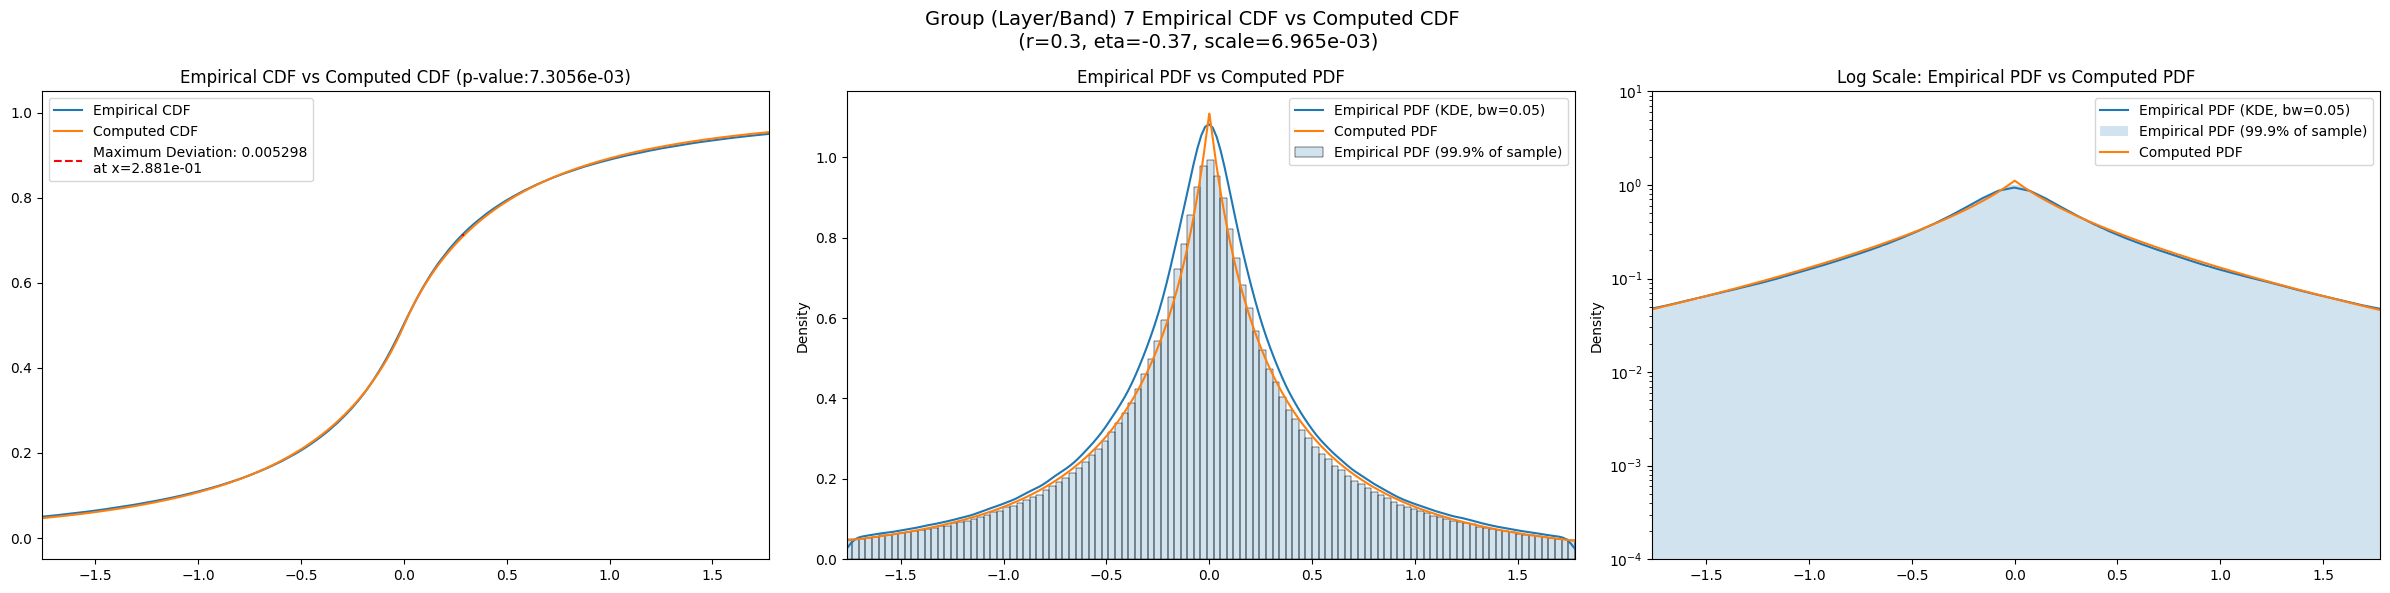

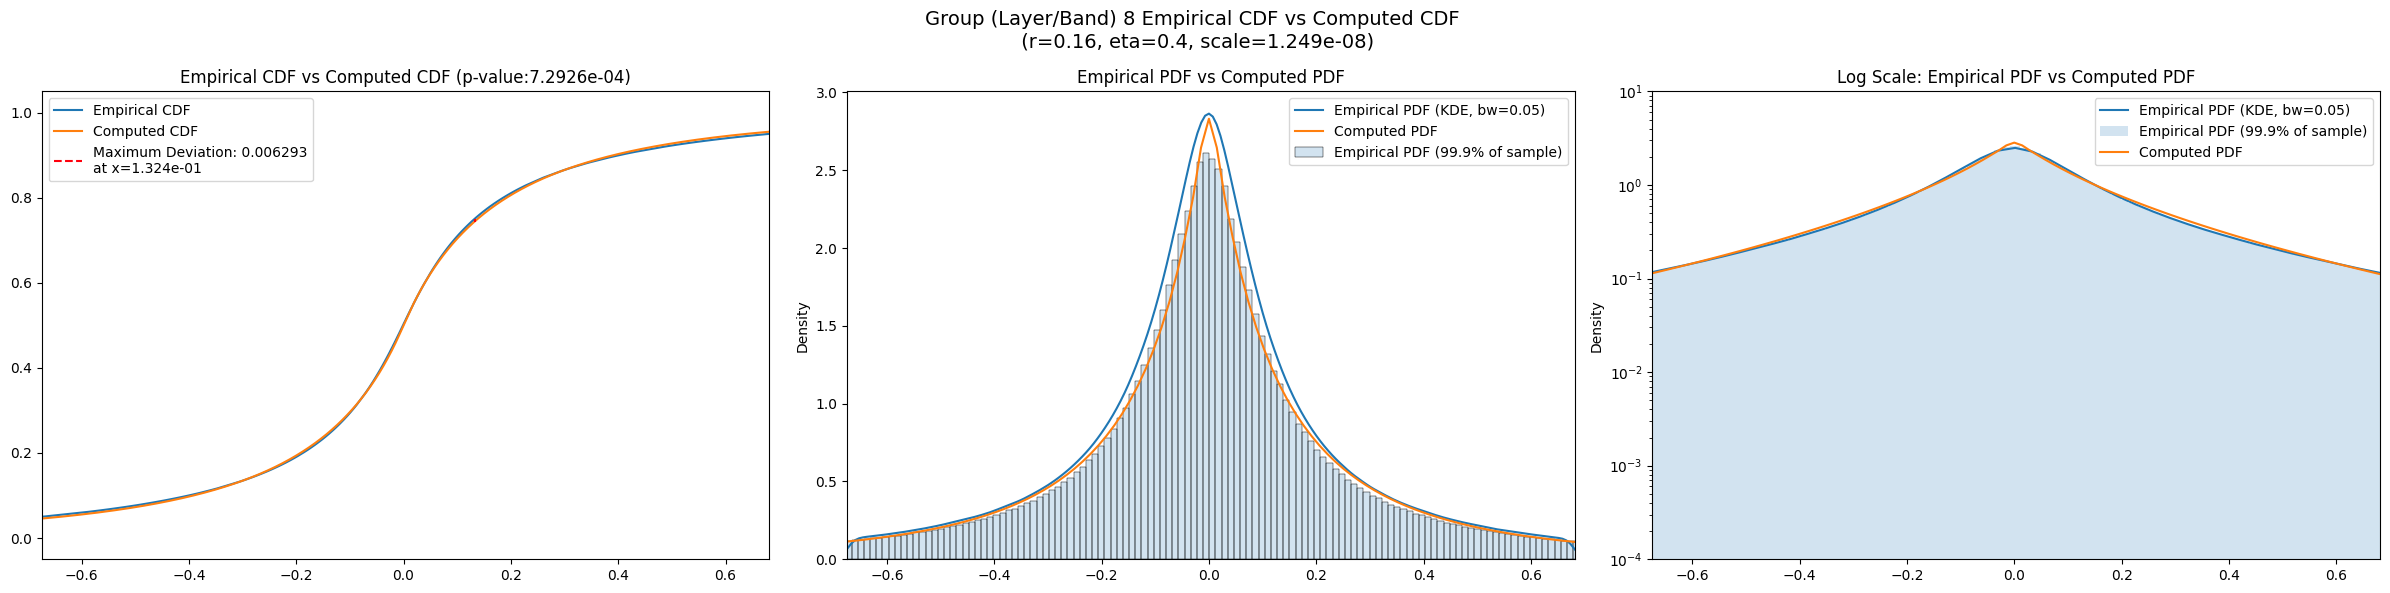

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1830.934600  1652.097700  2023.443800   2.933956    1.846394   
3       587.781860   556.332100   620.660600   2.604501    2.026207   
4       164.606740   154.984480   174.518840   3.278817    2.623241   
5        37.863530    35.388520    40.433693   4.789257    3.843992   
6         7.493805     6.929792     8.083941   6.740130    5.245897   
7         1.386997     1.272397     1.509542   9.084314    7.002164   
8         0.215883     0.196152     0.238341  12.285479    8.522737   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.126091         3180.0             0.016937        0.1          9.8   
3        3.270645        12720.0             0.004822        0.2          4.2   
4        4.093916        50880.0             0.004951        0.5          0.2   
5        5.925406       203520.0             0.002126        0.5         -0.3   
6        8.892210       814080.0             0.003349        0.4         -0.4   
7       12.550997      3256320.0             0.005556        0.3         -0.4   
8       23.484678     13025280.0             0.006952        0.2          0.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       35.216400              0.031319          3.822010e-03   
3      ...       20.655700              0.024528          4.427450e-07   
4      ...       10.162300              0.031252          1.316840e-43   
5      ...        4.515610              0.035460         8.879240e-223   
6      ...        1.793070              0.044345          0.000000e+00   
7      ...        0.681966              0.052539          0.000000e+00   
8      ...        0.251257              0.054679          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          32.501200             0.024581         4.216010e-02  26.626000   
3          18.039900             0.011071         8.783090e-02  14.504400   
4           8.964780             0.006986         1.386960e-02   7.271780   
5           3.970110             0.008324         1.122440e-12   3.217430   
6           1.573310             0.016709        7.339210e-198   1.264930   
7           0.598612             0.025074         0.000000e+00   0.477583   
8           0.221562             0.027676         0.000000e+00   0.175920   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.019259   1.864510e-01          3.177125e-01  
3           0.013417   2.033730e-02          9.308177e-01  
4           0.009676   1.446960e-04          1.767188e-01  
5           0.011171   1.721960e-22          3.539026e-01  
6           0.018767  1.707540e-249          4.501047e-07  
7           0.025556   0.000000e+00          2.285943e-73  
8           0.025922   0.000000e+00          0.000000e+00  

[7 rows x 30 columns]

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.016937                 0.024030          0.016937   
3                 0.004822                 0.012029          0.004791   
4                 0.004951                 0.006018          0.004879   
5                 0.002126                 0.003010          0.002059   
6                 0.003349                 0.001505          0.003066   
7                 0.005556                 0.000753          0.005078   
8                 0.006952                 0.000376          0.006035   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.031319             0.024581       0.019259  
3                  0.024528             0.011071       0.013417  
4                  0.031252             0.006986       0.009676  
5                  0.035460             0.008324       0.011171  
6                  0.044345             0.016709       0.018767  
7                  0.052539             0.025074       0.025556  
8                  0.054679             0.027676       0.025922

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             1830.934600          0.016937    0.10      9.80  3.660938e-18   
3              587.781860          0.004791    0.21      3.90  8.138773e-05   
4              159.676453          0.004879    0.58      0.00  2.516293e+01   
5               37.863529          0.002059    0.46     -0.20  2.703940e+00   
6                7.288052          0.003066    0.40     -0.39  3.268085e-01   
7                1.341698          0.005078    0.30     -0.37  6.965467e-03   
8                0.215883          0.006035    0.16      0.40  1.248581e-08   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                     25.0  
5                      0.0  
6                     25.0  
7                     25.0  
8                      0.0

In [22]:
eng.quit()